In [1]:
# Import required packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

In [2]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Step 1: Read the CSV file
csv_file_path = 'BBBP.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)

# Step 2: Extract SMILES strings from the fourth column
smiles_column = df.iloc[:, 3]

# Identify all unique molecules in the dataset
all_molecules = set("".join(smiles_column))

# Step 3: Create a one-hot encoder
one_hot_encoder = OneHotEncoder(sparse=False, categories='auto')

# Fit the encoder on the unique molecules
one_hot_encoder.fit([[mol] for mol in all_molecules])

# Step 4: Encode each structure into a vector
encoded_structures = []

for smiles in smiles_column:
    # Transform the SMILES string into a list of characters
    mol_chars = list(smiles)

    # Transform each character into its one-hot vector
    mol_one_hot = one_hot_encoder.transform([[char] for char in mol_chars])

    # Sum the one-hot vectors to obtain the structure vector
    structure_vector = mol_one_hot.sum(axis=0)

    # Append the structure vector to the list
    encoded_structures.append(structure_vector)

# Convert the list of structure vectors to a DataFrame
encoded_df = pd.DataFrame(encoded_structures)

# Add labels and other columns from the original DataFrame
encoded_df['Label'] = df['p_np']  # Assuming 'Label' is the column with labels



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


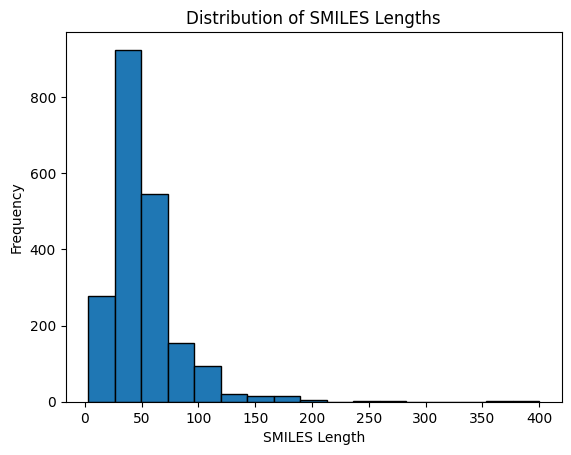

In [3]:
# Calculate the length of each SMILES
df['smiles_length'] = df['smiles'].apply(len)

# Display a histogram of the distribution of string lengths
plt.hist(df['smiles_length'], bins=17, edgecolor='black')
plt.title('Distribution of SMILES Lengths')
plt.xlabel('SMILES Length')
plt.ylabel('Frequency')
plt.show()

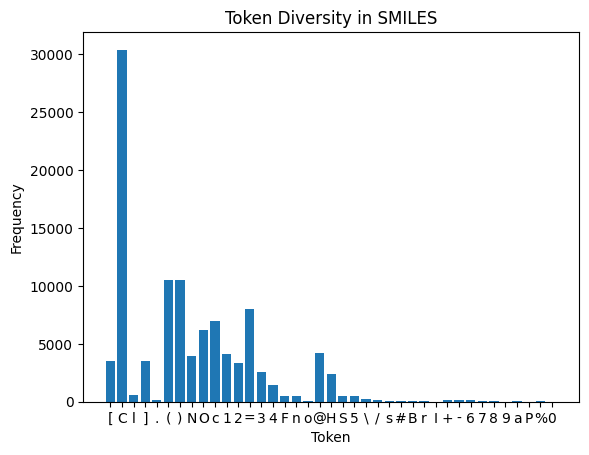

In [4]:
all_smiles = ''.join(df['smiles'])
tokens = [char for char in all_smiles]

# Calculate the frequency of each token
token_counts = Counter(tokens)

# Display a bar chart of token diversity
plt.bar(token_counts.keys(), token_counts.values())
plt.title('Token Diversity in SMILES')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.show()

#Fully Connected(Baseline)

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset




X = encoded_df.iloc[:, :-1].values
y = encoded_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train_tensor = X_train_tensor.view(-1, 39)
X_test_tensor = X_test_tensor.view(-1, 39)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = SimpleNN(input_size=39)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        model.eval()
        y_train_pred = (model(X_train_tensor) > 0.5).float().numpy()
    train_accuracy = accuracy_score(y_train, y_train_pred)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy * 100:.2f}%')



with torch.no_grad():
    model.eval()
    y_pred = (model(X_test_tensor) > 0.5).float().numpy()

test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/10, Train Accuracy: 83.78%
Epoch 2/10, Train Accuracy: 87.20%
Epoch 3/10, Train Accuracy: 87.01%
Epoch 4/10, Train Accuracy: 87.80%
Epoch 5/10, Train Accuracy: 88.41%
Epoch 6/10, Train Accuracy: 88.41%
Epoch 7/10, Train Accuracy: 88.78%
Epoch 8/10, Train Accuracy: 88.05%
Epoch 9/10, Train Accuracy: 89.02%
Epoch 10/10, Train Accuracy: 89.76%
Test Accuracy: 86.83%


#ز

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'encoded_df' is your dataframe
X = encoded_df.iloc[:, :-1].values
y = encoded_df.iloc[:, -1].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the sum of each column in X_test before scaling
column_sums = np.sum(X_test, axis=1)

# Divide data into 10 bins
hist_values, bin_edges = np.histogram(column_sums, bins=10)

# Assign each data point in X_test to a bin
bin_indices = np.digitize(column_sums, bins=bin_edges, right=True)

# Initialize a list to store DataLoader for each bin
bin_loaders = []

# Iterate over each bin and evaluate the model on datasets of each bin
# Iterate over each bin and evaluate the model on datasets of each bin
for bin_id in range(1, 11):  # Bins are indexed from 1 to 10
    # Select data points in the current bin
    bin_X_test = X_test[bin_indices == bin_id]
    bin_y_test = y_test[bin_indices == bin_id]

    # Check if the bin is not empty before standardizing
    if bin_X_test.shape[0] > 0:
        # Standardize the data using the scaler fitted on X_train
        bin_X_test = scaler.transform(bin_X_test.reshape(-1, 1)).reshape(-1, X_test.shape[1])

        # Convert to PyTorch tensors
        bin_X_test_tensor = torch.tensor(bin_X_test, dtype=torch.float32)
        bin_y_test_tensor = torch.tensor(bin_y_test, dtype=torch.float32)

        # Create a DataLoader for the current bin
        bin_dataset = TensorDataset(bin_X_test_tensor, bin_y_test_tensor)
        bin_loader = DataLoader(bin_dataset, batch_size=1, shuffle=False)

        # Evaluate the model on the current bin
        model.eval()
        all_predictions_bin = []
        all_labels_bin = []

        with torch.no_grad():
            for inputs_bin, labels_bin in bin_loader:
                outputs_bin = model(inputs_bin)
                predictions_bin = (outputs_bin > 0.5).float().numpy()
                all_predictions_bin.extend(predictions_bin)
                all_labels_bin.extend(labels_bin.numpy())

        # Calculate test accuracy for the current bin
        test_accuracy_bin = accuracy_score(all_labels_bin, all_predictions_bin)
        print(f'Bin {bin_id}/10, Test Accuracy: {test_accuracy_bin * 100:.2f}%')
        bin_loaders.append(bin_loader)
    else:
        print(f'Bin {bin_id}/10 is empty. Skipping evaluation.')



Bin 1/10, Test Accuracy: 83.23%
Bin 2/10, Test Accuracy: 89.95%
Bin 3/10, Test Accuracy: 80.85%
Bin 4/10, Test Accuracy: 100.00%
Bin 5/10, Test Accuracy: 100.00%
Bin 6/10, Test Accuracy: 100.00%
Bin 7/10 is empty. Skipping evaluation.
Bin 8/10 is empty. Skipping evaluation.
Bin 9/10 is empty. Skipping evaluation.
Bin 10/10, Test Accuracy: 100.00%


#LSTM

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define a list of SMILES symbols
smiles_symbols = ['C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I', 'H', 'B', 'Si', ' ', '(', ')', '=', '#', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '+', '-', '[', ']', '@', '%', '.', '/']

# Function to tokenize a SMILES string and create one-hot encodings
def tokenize_smiles(smiles):
    tokens = []
    i = 0
    while i < len(smiles):
        char = smiles[i]
        if char in smiles_symbols:
            # Check if the next character forms a two-character element
            potential_element = char + smiles[i + 1] if i + 1 < len(smiles) else None
            if potential_element in smiles_symbols:
                tokens.append(smiles_symbols.index(potential_element))
                i += 2  # Skip the next character for a two-character element
            else:
                tokens.append(smiles_symbols.index(char))
                i += 1
        else:
            # Handle other characters (non-SMILES symbols)
            tokens.append(len(smiles_symbols))  # Assign a special index for non-SMILES symbols
            i += 1
    return tokens

# Function to convert a list of SMILES strings to a list of one-hot encoded vectors
def encode_smiles_strings(smiles_strings):
    encoded_list = []
    for smiles_string in smiles_strings:
        tokenized_smiles = tokenize_smiles(smiles_string)
        one_hot_encoding = np.zeros((len(tokenized_smiles), len(smiles_symbols) + 1))  # +1 for the special index
        for i, token in enumerate(tokenized_smiles):
            one_hot_encoding[i, token] = 1
        encoded_list.append(one_hot_encoding)
    return encoded_list

# PyTorch dataset class for SMILES data
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, labels):
        self.smiles_list = smiles_list
        self.labels = labels

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        return torch.tensor(self.smiles_list[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# LSTM model for classification
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        flattened = self.flatten(lstm_out[:, -1, :])  # Take the output of the last time step
        output = self.sigmoid(self.fc(flattened))
        return output

# Read CSV file and extract SMILES strings and labels
csv_file_path = 'BBBP.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)
smiles_column = df.iloc[:, 3]
labels = df.iloc[:, 2].values  # Assuming labels are in the third column

# Tokenize and encode SMILES strings
encoded_smiles_list = encode_smiles_strings(smiles_column)


X_train, X_test, y_train, y_test = train_test_split(encoded_smiles_list, labels, test_size = 0.2, random_state = 0)
train_dataset = SMILESDataset(X_train, y_train)
test_dataset = SMILESDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Instantiate the LSTM model
input_size = len(smiles_symbols) + 1  # +1 for the special index
hidden_size = 64
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model


In [50]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Calculate training accuracy after each epoch
    with torch.no_grad():
          model.eval()
          all_predictions = []
          all_labels = []
          for inputs, labels in train_loader:
             outputs = model(inputs)
             predictions = (outputs > 0.5).float().numpy()
             all_predictions.extend(predictions)
             all_labels.extend(labels.numpy())
    train_accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy * 100:.2f}%')

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs > 0.5).float().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/10, Train Accuracy: 83.35%
Epoch 2/10, Train Accuracy: 87.80%
Epoch 3/10, Train Accuracy: 87.07%
Epoch 4/10, Train Accuracy: 89.57%
Epoch 5/10, Train Accuracy: 88.84%
Epoch 6/10, Train Accuracy: 90.91%
Epoch 7/10, Train Accuracy: 90.91%
Epoch 8/10, Train Accuracy: 91.95%
Epoch 9/10, Train Accuracy: 89.27%
Epoch 10/10, Train Accuracy: 91.83%
Test Accuracy: 87.07%


#ز

In [51]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# ... (Rest of the code remains unchanged)

# Function to calculate the length of SMILES strings
def calculate_smiles_length(smiles):
    return len(smiles)

# Add a column for SMILES lengths to the DataFrame
df['SMILES_Length'] = df['smiles'].apply(calculate_smiles_length)

# Create 10 bins based on the SMILES lengths
df['Bin'] = pd.qcut(df['SMILES_Length'], q=10, labels=False)


# Define loss function
criterion = nn.BCELoss()


# Evaluate the model on each bin
for bin_id in range(10):
    # Select data points in the current bin
    bin_data = df[df['Bin'] == bin_id]

    # Extract SMILES strings and labels
    smiles_column_bin = bin_data['smiles']
    labels_bin = bin_data['p_np'].values

    # Tokenize and encode SMILES strings
    encoded_smiles_list_bin = encode_smiles_strings(smiles_column_bin)

    # Create data loader
    dataset_bin = SMILESDataset(encoded_smiles_list_bin, labels_bin)
    loader_bin = DataLoader(dataset_bin, batch_size=1, shuffle=False)

    # Evaluate the model on the test set for the current bin
    model.eval()
    all_predictions_bin = []
    all_labels_bin = []

    with torch.no_grad():
        for inputs_bin, labels_bin in loader_bin:
            outputs_bin = model(inputs_bin)
            predictions_bin = (outputs_bin > 0.5).float().numpy()
            all_predictions_bin.extend(predictions_bin)
            all_labels_bin.extend(labels_bin.numpy())

    # Calculate test accuracy for the current bin
    test_accuracy_bin = accuracy_score(all_labels_bin, all_predictions_bin)
    print(f'Bin {bin_id + 1}/10, Test Accuracy: {test_accuracy_bin * 100:.2f}%')


Bin 1/10, Test Accuracy: 88.58%
Bin 2/10, Test Accuracy: 86.60%
Bin 3/10, Test Accuracy: 87.74%
Bin 4/10, Test Accuracy: 92.98%
Bin 5/10, Test Accuracy: 92.27%
Bin 6/10, Test Accuracy: 89.95%
Bin 7/10, Test Accuracy: 91.87%
Bin 8/10, Test Accuracy: 93.98%
Bin 9/10, Test Accuracy: 94.15%
Bin 10/10, Test Accuracy: 90.69%


#BiLLSTM

In [52]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

# Define a list of SMILES symbols
smiles_symbols = ['C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I', 'H', 'B', 'Si', ' ', '(', ')', '=', '#', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '+', '-', '[', ']', '@', '%', '.', '/']

# Function to tokenize a SMILES string and create one-hot encodings
def tokenize_smiles(smiles):
    tokens = []
    i = 0
    while i < len(smiles):
        char = smiles[i]
        if char in smiles_symbols:
            # Check if the next character forms a two-character element
            potential_element = char + smiles[i + 1] if i + 1 < len(smiles) else None
            if potential_element in smiles_symbols:
                tokens.append(smiles_symbols.index(potential_element))
                i += 2  # Skip the next character for a two-character element
            else:
                tokens.append(smiles_symbols.index(char))
                i += 1
        else:
            # Handle other characters (non-SMILES symbols)
            tokens.append(len(smiles_symbols))  # Assign a special index for non-SMILES symbols
            i += 1
    return tokens

# Function to convert a list of SMILES strings to a list of one-hot encoded vectors
def encode_smiles_strings(smiles_strings):
    encoded_list = []
    for smiles_string in smiles_strings:
        tokenized_smiles = tokenize_smiles(smiles_string)
        one_hot_encoding = np.zeros((len(tokenized_smiles), len(smiles_symbols) + 1))  # +1 for the special index
        for i, token in enumerate(tokenized_smiles):
            one_hot_encoding[i, token] = 1
        encoded_list.append(one_hot_encoding)
    return encoded_list

# PyTorch dataset class for SMILES data
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, labels):
        self.smiles_list = smiles_list
        self.labels = labels

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        return torch.tensor(self.smiles_list[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Bidirectional LSTM model for classification
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply hidden_size by 2 for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        flattened = self.flatten(bilstm_out[:, -1, :])  # Take the output of the last time step
        output = self.sigmoid(self.fc(flattened))
        return output

# Read CSV file and extract SMILES strings and labels
csv_file_path = 'BBBP.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)
smiles_column = df.iloc[:, 3]
labels = df.iloc[:, 2].values  # Assuming labels are in the third column

# Tokenize and encode SMILES strings
encoded_smiles_list = encode_smiles_strings(smiles_column)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_smiles_list, labels, test_size = 0.2, random_state = 0)
train_dataset = SMILESDataset(X_train, y_train)
test_dataset = SMILESDataset(X_test, y_test)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Instantiate the BiLSTM model
input_size = len(smiles_symbols) + 1  # +1 for the special index
hidden_size = 64
num_layers = 2
output_size = 1
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Calculate training accuracy after each epoch
    with torch.no_grad():
          model.eval()
          all_predictions = []
          all_labels = []
          for inputs, labels in train_loader:
             outputs = model(inputs)
             predictions = (outputs > 0.5).float().numpy()
             all_predictions.extend(predictions)
             all_labels.extend(labels.numpy())
    train_accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy * 100:.2f}%')
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs > 0.5).float().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/10, Train Accuracy: 81.22%
Epoch 2/10, Train Accuracy: 78.17%
Epoch 3/10, Train Accuracy: 82.38%
Epoch 4/10, Train Accuracy: 79.82%
Epoch 5/10, Train Accuracy: 79.27%
Epoch 6/10, Train Accuracy: 83.23%
Epoch 7/10, Train Accuracy: 83.96%
Epoch 8/10, Train Accuracy: 84.21%
Epoch 9/10, Train Accuracy: 84.15%
Epoch 10/10, Train Accuracy: 85.67%
Test Accuracy: 84.39%


#ز

In [53]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# ... (Rest of the code remains unchanged)

# Function to calculate the length of SMILES strings
def calculate_smiles_length(smiles):
    return len(smiles)

# Add a column for SMILES lengths to the DataFrame
df['SMILES_Length'] = df['smiles'].apply(calculate_smiles_length)

# Create 10 bins based on the SMILES lengths
df['Bin'] = pd.qcut(df['SMILES_Length'], q=10, labels=False)


# Define loss function
criterion = nn.BCELoss()


# Evaluate the model on each bin
for bin_id in range(10):
    # Select data points in the current bin
    bin_data = df[df['Bin'] == bin_id]

    # Extract SMILES strings and labels
    smiles_column_bin = bin_data['smiles']
    labels_bin = bin_data['p_np'].values

    # Tokenize and encode SMILES strings
    encoded_smiles_list_bin = encode_smiles_strings(smiles_column_bin)

    # Create data loader
    dataset_bin = SMILESDataset(encoded_smiles_list_bin, labels_bin)
    loader_bin = DataLoader(dataset_bin, batch_size=1, shuffle=False)

    # Evaluate the model on the test set for the current bin
    model.eval()
    all_predictions_bin = []
    all_labels_bin = []

    with torch.no_grad():
        for inputs_bin, labels_bin in loader_bin:
            outputs_bin = model(inputs_bin)
            predictions_bin = (outputs_bin > 0.5).float().numpy()
            all_predictions_bin.extend(predictions_bin)
            all_labels_bin.extend(labels_bin.numpy())

    # Calculate test accuracy for the current bin
    test_accuracy_bin = accuracy_score(all_labels_bin, all_predictions_bin)
    print(f'Bin {bin_id + 1}/10, Test Accuracy: {test_accuracy_bin * 100:.2f}%')


Bin 1/10, Test Accuracy: 84.47%
Bin 2/10, Test Accuracy: 85.05%
Bin 3/10, Test Accuracy: 88.21%
Bin 4/10, Test Accuracy: 93.86%
Bin 5/10, Test Accuracy: 88.40%
Bin 6/10, Test Accuracy: 85.93%
Bin 7/10, Test Accuracy: 85.65%
Bin 8/10, Test Accuracy: 82.87%
Bin 9/10, Test Accuracy: 81.38%
Bin 10/10, Test Accuracy: 77.45%


#ه

#FC

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'encoded_df' is your dataframe containing the data

X = encoded_df.iloc[:, :-1].values
y = encoded_df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_tensor = X_tensor.view(-1, 39)

# Define k-fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize model, criterion, and optimizer
model = SimpleNN(input_size=39)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store accuracy for each fold
train_accuracies = []
test_accuracies = []

# Perform k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train_fold, X_test_fold = X_tensor[train_idx], X_tensor[test_idx]
    y_train_fold, y_test_fold = y_tensor[train_idx], y_tensor[test_idx]

    train_dataset_fold = TensorDataset(X_train_fold, y_train_fold)
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()

        for inputs, labels in train_loader_fold:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        model.eval()
        y_train_pred_fold = (model(X_train_fold) > 0.5).float().numpy()
    train_accuracy_fold = accuracy_score(y_train_fold, y_train_pred_fold)
    train_accuracies.append(train_accuracy_fold)
    print(f'Fold {fold + 1}/{kf.get_n_splits()}, Train Accuracy: {train_accuracy_fold * 100:.2f}%')

    with torch.no_grad():
        model.eval()
        y_pred_fold = (model(X_test_fold) > 0.5).float().numpy()

    test_accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    test_accuracies.append(test_accuracy_fold)
    print(f'Fold {fold + 1}/{kf.get_n_splits()}, Test Accuracy: {test_accuracy_fold * 100:.2f}%')

# Calculate and print the average accuracy
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
print(f'\nAverage Train Accuracy: {avg_train_accuracy * 100:.2f}%')
print(f'Average Test Accuracy: {avg_test_accuracy * 100:.2f}%')


Fold 1/5, Train Accuracy: 92.13%
Fold 1/5, Test Accuracy: 87.07%
Fold 2/5, Train Accuracy: 95.24%
Fold 2/5, Test Accuracy: 92.44%
Fold 3/5, Train Accuracy: 96.65%
Fold 3/5, Test Accuracy: 91.46%
Fold 4/5, Train Accuracy: 97.32%
Fold 4/5, Test Accuracy: 93.90%
Fold 5/5, Train Accuracy: 97.62%
Fold 5/5, Test Accuracy: 95.12%

Average Train Accuracy: 95.79%
Average Test Accuracy: 92.00%


#LSTM

In [27]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define a list of SMILES symbols
smiles_symbols = ['C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I', 'H', 'B', 'Si', ' ', '(', ')', '=', '#', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '+', '-', '[', ']', '@', '%', '.', '/']

# Function to tokenize a SMILES string and create one-hot encodings
def tokenize_smiles(smiles):
    tokens = []
    i = 0
    while i < len(smiles):
        char = smiles[i]
        if char in smiles_symbols:
            # Check if the next character forms a two-character element
            potential_element = char + smiles[i + 1] if i + 1 < len(smiles) else None
            if potential_element in smiles_symbols:
                tokens.append(smiles_symbols.index(potential_element))
                i += 2  # Skip the next character for a two-character element
            else:
                tokens.append(smiles_symbols.index(char))
                i += 1
        else:
            # Handle other characters (non-SMILES symbols)
            tokens.append(len(smiles_symbols))  # Assign a special index for non-SMILES symbols
            i += 1
    return tokens

# Function to convert a list of SMILES strings to a list of one-hot encoded vectors
def encode_smiles_strings(smiles_strings):
    encoded_list = []
    for smiles_string in smiles_strings:
        tokenized_smiles = tokenize_smiles(smiles_string)
        one_hot_encoding = np.zeros((len(tokenized_smiles), len(smiles_symbols) + 1))  # +1 for the special index
        for i, token in enumerate(tokenized_smiles):
            one_hot_encoding[i, token] = 1
        encoded_list.append(one_hot_encoding)
    return encoded_list

# PyTorch dataset class for SMILES data
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, labels):
        self.smiles_list = smiles_list
        self.labels = labels

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        return torch.tensor(self.smiles_list[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# LSTM model for classification
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        flattened = self.flatten(lstm_out[:, -1, :])  # Take the output of the last time step
        output = self.sigmoid(self.fc(flattened))
        return output

# Read CSV file and extract SMILES strings and labels
csv_file_path = 'BBBP.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)
smiles_column = df.iloc[:, 3]
labels = df.iloc[:, 2].values  # Assuming labels are in the third column

# Tokenize and encode SMILES strings
encoded_smiles_list = encode_smiles_strings(smiles_column)


X_train, X_test, y_train, y_test = train_test_split(encoded_smiles_list, labels, test_size = 0.2, random_state = 0)
train_dataset = SMILESDataset(X_train, y_train)
test_dataset = SMILESDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Lists to store accuracy for each fold
train_accuracies = []
test_accuracies = []
encoded_smiles_list = np.array(encoded_smiles_list)

labels_array = np.array(labels)
# Perform k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(encoded_smiles_list, labels_array)):
    X_train_fold, X_test_fold = encoded_smiles_list[train_idx], encoded_smiles_list[test_idx]
    y_train_fold, y_test_fold = labels_array[train_idx], labels_array[test_idx]

    train_dataset_fold = SMILESDataset(X_train_fold, y_train_fold)
    test_dataset_fold = SMILESDataset(X_test_fold, y_test_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=1, shuffle=True)
    test_loader_fold = DataLoader(test_dataset_fold, batch_size=1, shuffle=False)

    input_size = len(smiles_symbols) + 1
    hidden_size = 64
    num_layers = 2
    output_size = 1

    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()

        for inputs, labels in train_loader_fold:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

    # Calculate training accuracy after each epoch
    with torch.no_grad():
        model.eval()
        all_predictions_train = []
        all_labels_train = []
        for inputs, labels in train_loader_fold:
            outputs = model(inputs)
            predictions_train = (outputs > 0.5).float().numpy()
            all_predictions_train.extend(predictions_train)
            all_labels_train.extend(labels.numpy())
    train_accuracy_fold = accuracy_score(all_labels_train, all_predictions_train)
    train_accuracies.append(train_accuracy_fold)
    print(f'Fold {fold + 1}/{kf.get_n_splits()}, Train Accuracy: {train_accuracy_fold * 100:.2f}%')

    # Evaluate the model on the test set
    with torch.no_grad():
        model.eval()
        all_predictions_test = []
        all_labels_test = []
        for inputs, labels in test_loader_fold:
            outputs = model(inputs)
            predictions_test = (outputs > 0.5).float().numpy()
            all_predictions_test.extend(predictions_test)
            all_labels_test.extend(labels.numpy())

    # Calculate test accuracy
    test_accuracy_fold = accuracy_score(all_labels_test, all_predictions_test)
    test_accuracies.append(test_accuracy_fold)
    print(f'Fold {fold + 1}/{kf.get_n_splits()}, Test Accuracy: {test_accuracy_fold * 100:.2f}%')

# Calculate and print the average accuracy
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
print(f'\nAverage Train Accuracy: {avg_train_accuracy * 100:.2f}%')
print(f'Average Test Accuracy: {avg_test_accuracy * 100:.2f}%')


<ipython-input-27-211713bfacf1>:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded_smiles_list = np.array(encoded_smiles_list)


Fold 1/5, Train Accuracy: 89.21%
Fold 1/5, Test Accuracy: 85.12%
Fold 2/5, Train Accuracy: 88.66%
Fold 2/5, Test Accuracy: 84.39%
Fold 3/5, Train Accuracy: 91.22%
Fold 3/5, Test Accuracy: 86.34%
Fold 4/5, Train Accuracy: 85.24%
Fold 4/5, Test Accuracy: 80.00%
Fold 5/5, Train Accuracy: 90.00%
Fold 5/5, Test Accuracy: 87.32%

Average Train Accuracy: 88.87%
Average Test Accuracy: 84.63%


In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply hidden_size by 2 for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        flattened = self.flatten(bilstm_out[:, -1, :])  # Take the output of the last time step
        output = self.sigmoid(self.fc(flattened))
        return output


#BILSTM

In [26]:
print(labels_array)


[1 1 1 ... 1 1 1]


In [28]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define a list of SMILES symbols
smiles_symbols = ['C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I', 'H', 'B', 'Si', ' ', '(', ')', '=', '#', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '+', '-', '[', ']', '@', '%', '.', '/']

# Function to tokenize a SMILES string and create one-hot encodings
def tokenize_smiles(smiles):
    tokens = []
    i = 0
    while i < len(smiles):
        char = smiles[i]
        if char in smiles_symbols:
            # Check if the next character forms a two-character element
            potential_element = char + smiles[i + 1] if i + 1 < len(smiles) else None
            if potential_element in smiles_symbols:
                tokens.append(smiles_symbols.index(potential_element))
                i += 2  # Skip the next character for a two-character element
            else:
                tokens.append(smiles_symbols.index(char))
                i += 1
        else:
            # Handle other characters (non-SMILES symbols)
            tokens.append(len(smiles_symbols))  # Assign a special index for non-SMILES symbols
            i += 1
    return tokens

# Function to convert a list of SMILES strings to a list of one-hot encoded vectors
def encode_smiles_strings(smiles_strings):
    encoded_list = []
    for smiles_string in smiles_strings:
        tokenized_smiles = tokenize_smiles(smiles_string)
        one_hot_encoding = np.zeros((len(tokenized_smiles), len(smiles_symbols) + 1))  # +1 for the special index
        for i, token in enumerate(tokenized_smiles):
            one_hot_encoding[i, token] = 1
        encoded_list.append(one_hot_encoding)
    return encoded_list

# PyTorch dataset class for SMILES data
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, labels):
        self.smiles_list = smiles_list
        self.labels = labels

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        return torch.tensor(self.smiles_list[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# LSTM model for classification
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply hidden_size by 2 for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        flattened = self.flatten(bilstm_out[:, -1, :])  # Take the output of the last time step
        output = self.sigmoid(self.fc(flattened))
        return output

# Read CSV file and extract SMILES strings and labels
csv_file_path = 'BBBP.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)
smiles_column = df.iloc[:, 3]
labels = df.iloc[:, 2].values  # Assuming labels are in the third column

# Tokenize and encode SMILES strings
encoded_smiles_list = encode_smiles_strings(smiles_column)


X_train, X_test, y_train, y_test = train_test_split(encoded_smiles_list, labels, test_size = 0.2, random_state = 0)
train_dataset = SMILESDataset(X_train, y_train)
test_dataset = SMILESDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Lists to store accuracy for each fold
train_accuracies = []
test_accuracies = []
encoded_smiles_list = np.array(encoded_smiles_list)

labels_array = np.array(labels)
# Perform k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(encoded_smiles_list, labels_array)):
    X_train_fold, X_test_fold = encoded_smiles_list[train_idx], encoded_smiles_list[test_idx]
    y_train_fold, y_test_fold = labels_array[train_idx], labels_array[test_idx]

    train_dataset_fold = SMILESDataset(X_train_fold, y_train_fold)
    test_dataset_fold = SMILESDataset(X_test_fold, y_test_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=1, shuffle=True)
    test_loader_fold = DataLoader(test_dataset_fold, batch_size=1, shuffle=False)

    input_size = len(smiles_symbols) + 1
    hidden_size = 64
    num_layers = 2
    output_size = 1

    model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()

        for inputs, labels in train_loader_fold:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

    # Calculate training accuracy after each epoch
    with torch.no_grad():
        model.eval()
        all_predictions_train = []
        all_labels_train = []
        for inputs, labels in train_loader_fold:
            outputs = model(inputs)
            predictions_train = (outputs > 0.5).float().numpy()
            all_predictions_train.extend(predictions_train)
            all_labels_train.extend(labels.numpy())
    train_accuracy_fold = accuracy_score(all_labels_train, all_predictions_train)
    train_accuracies.append(train_accuracy_fold)
    print(f'Fold {fold + 1}/{kf.get_n_splits()}, Train Accuracy: {train_accuracy_fold * 100:.2f}%')

    # Evaluate the model on the test set
    with torch.no_grad():
        model.eval()
        all_predictions_test = []
        all_labels_test = []
        for inputs, labels in test_loader_fold:
            outputs = model(inputs)
            predictions_test = (outputs > 0.5).float().numpy()
            all_predictions_test.extend(predictions_test)
            all_labels_test.extend(labels.numpy())

    # Calculate test accuracy
    test_accuracy_fold = accuracy_score(all_labels_test, all_predictions_test)
    test_accuracies.append(test_accuracy_fold)
    print(f'Fold {fold + 1}/{kf.get_n_splits()}, Test Accuracy: {test_accuracy_fold * 100:.2f}%')

# Calculate and print the average accuracy
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
print(f'\nAverage Train Accuracy: {avg_train_accuracy * 100:.2f}%')
print(f'Average Test Accuracy: {avg_test_accuracy * 100:.2f}%')


<ipython-input-28-fdb04a1e6a5b>:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded_smiles_list = np.array(encoded_smiles_list)


Fold 1/5, Train Accuracy: 84.15%
Fold 1/5, Test Accuracy: 82.44%
Fold 2/5, Train Accuracy: 90.18%
Fold 2/5, Test Accuracy: 84.88%
Fold 3/5, Train Accuracy: 90.24%
Fold 3/5, Test Accuracy: 87.56%
Fold 4/5, Train Accuracy: 88.96%
Fold 4/5, Test Accuracy: 84.88%
Fold 5/5, Train Accuracy: 89.57%
Fold 5/5, Test Accuracy: 86.83%

Average Train Accuracy: 88.62%
Average Test Accuracy: 85.32%


#و

فرق این دو مدل به نحوی است که باید اولا جنس داده به گونه ای باشد که اطلاع از اینده در تصمیم گیری الان ما نقش داشته باشد یا خیر

قاعدتا دیتا ما جنسش خیلی اینگونه نمی باشد  و بیشتر متکی بر توالی می باشد تا اطلاع از اینده.

اما به هرحال بایستی با لرن شدن بیشتر و دیتا های متنوع تر

Bilstm

 حداقل به
 LSTM

 برسد اما به دلیل دیتا های ناکافی قدرت جنرالیزیشن زیادی ندارد

 به همین دلیل جنس دیتا که خیلی کامپتیبل با

 Bilstm

 نبود و دیتا های ناکافی منجر به همچین اختلافی میشد

#ز



این قسمت را در هر بخش انجام دادیم



چیزی که مشاهده کردیم در

FC

با افزایش سایز دقت زیاد میشد

در دو مدل دیگر هم چنین بود اما نوساناتی داشتیم


که این به این مربوط است که ممکن است با افزایش  طول در دو مدل دیگر نابودی گرادیان به وجود بیاید و برای دیتای بیشتری این مذل ها خوب کار می کند ولی این داستان برای مذل

FC

 فرقی ندارد و روند صعودی خودش را دارد